# Knowledge Graph Project (FORWARD Data Lab)

![logo](./logo.png)

## Part 1. ETL Pipeline

### Load libraries

In [1]:
import pyspark as sp
import numpy as np
import string
import re

### Set environment variable (optional)

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3" 
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

### Setup cluster

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession \
    .builder \
    .appName("Python Knowledge Graph Project") \
    .config("spark.driver.memory", "55g") \
    .master("local[*]") \
    .getOrCreate()

###  Load dataset

- Documents: `1.7m` documents (arXiv dataset)
- Keyword list: `100,000` keywords (FORWARD Data Lab)
- Download your documents here: https://www.kaggle.com/Cornell-University/arxiv.

In [4]:
df_keywords = spark.read.csv("./mag_cs_keywords.csv",header=True)
df_arxiv = spark.read.json("./arxiv-metadata-oai-snapshot.json")

In [5]:
df_keywords = df_keywords.repartition(16)
df_arxiv = df_arxiv.repartition(16)

In [6]:
df_keywords.rdd.getNumPartitions()

16

In [7]:
df_keywords.count()

104654

In [8]:
abstracts = df_arxiv.select("id","abstract")
keywords = df_keywords.select("normalizedName")

### Cleaning & Normalization

In [9]:
from pyspark.sql.functions import udf, col
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType

# get only lowercase alphabets
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c.lower() for c in data_str if 96 < ord(c.lower()) < 123 or ord(c)==32) #alphabets

    return ''.join(stripped)
# setup pyspark udf function
strip_non_ascii_udf = udf(strip_non_ascii, StringType())

In [10]:
abstracts = abstracts.withColumn('normalized', strip_non_ascii_udf(abstracts['abstract']))
abstracts = abstracts.select("id","normalized")

In [11]:
abstracts.show()

+---------+--------------------+
|       id|          normalized|
+---------+--------------------+
|0705.2030|  the group eso s...|
|0801.0970|  this paper is c...|
|0709.3236|  we present a ge...|
|0809.3030|  the tragedy of ...|
|0712.0290|  the ability to ...|
|0805.2349|  this article pr...|
|0805.1292|  we turn the chu...|
|0712.3567|  the random sequ...|
|0705.1654|  a smallscale tr...|
|0803.3867|  we present a ch...|
|0709.0351|  for precision s...|
|0711.4659|  in a newly intr...|
|0705.1358|  we propose two ...|
|0710.2002|  we present prec...|
|0801.1957|  we calculate th...|
|0707.0756|  many topologica...|
|0808.0066|  the reasonablen...|
|0801.3027|  in this paper w...|
|0707.0344|  in this paper w...|
|0807.4946|  we establish lo...|
+---------+--------------------+
only showing top 20 rows



### Keyword List for Query

- `keywords_dict` : Hash table is used to find whether documents contain keywords
- My frist attempt was using regular expression (re.findall()). 
- When using regular expression, there could be a time complexity issue due to unnecessary computational overhead
- To optimize algorithm, we should search `from document to word`. 

In [12]:
keywords_list = list(keywords.select('normalizedName').toPandas()['normalizedName'])
keyword_dict = {word:0 for word in keywords_list}

### Extract Keyword from the keyword list

In [13]:
import re, nltk

# Define the function you want to return
def extract(s):
    all_matches = set()
    
    ngrams = list()
    ngrams.append(s.split(" "))
    for i in range(1,12): # all ngrams in keyword list
        ngrams.append(nltk.ngrams(ngrams[0], i))
    
    for ngram in ngrams: 
        for token in ngram:
            token = ' '.join(token)
            if keyword_dict.get(token, -1) >=0: 
                keyword_dict[token] += 1
                all_matches.add(token)
    return ','.join(all_matches)

# Create the UDF, note that you need to declare the return schema matching the returned type
extract_udf = udf(extract, StringType())

# Apply it
df = abstracts.withColumn('extracted', extract_udf(abstracts['normalized']))

In [14]:
df.show()

+---------+--------------------+--------------------+
|       id|          normalized|           extracted|
+---------+--------------------+--------------------+
|0705.2030|  the group eso s...|power,momentum,ro...|
|0801.0970|  this paper is c...|selection,minimax...|
|0709.3236|  we present a ge...|perturbation theo...|
|0809.3030|  the tragedy of ...|set,crowdsourcing...|
|0712.0290|  the ability to ...|mechanism,morphol...|
|0805.2349|  this article pr...|liquid helium,pha...|
|0805.1292|  we turn the chu...|physics,computati...|
|0712.3567|  the random sequ...|deposition,initia...|
|0705.1654|  a smallscale tr...|thermal,temperatu...|
|0803.3867|  we present a ch...|        product,term|
|0709.0351|  for precision s...|field,perturbatio...|
|0711.4659|  in a newly intr...|square,phase,posi...|
|0705.1358|  we propose two ...|phase,phase trans...|
|0710.2002|  we present prec...|pair production,d...|
|0801.1957|  we calculate th...|quantum,phase,fie...|
|0707.0756|  many topologica

$$ PMI(A,B) = \frac{P(A,B)}{P(A)*P(B)}$$

$$ P(A,B) = \frac{c((A,B), C_{\text{pairs}})}{c(C_{\text{pairs}})} $$

$$ P(A) = \frac{c(A)}{c(C)}, P(B) = \frac{c(B)}{c(C)} $$

$$ \text{where C stands for word collection} $$

### 1. Get Word Count 

- `corpus`: It is a dictionary of keywords

In [15]:
corpus_temp = df.select("extracted").rdd.repartition(16).flatMap(lambda x: (x["extracted"].split(",")))
corpus = corpus_temp.countByValue()

In [53]:
len(corpus)

70342

### 2. Get Cooccurence Count
- `corpus2` : It is a dictionary where key is tuple (pair of keywords) and value is frequency

In [16]:
rdds = df.select("extracted").rdd.repartition(16).map(lambda x: x['extracted'].split(","))

In [17]:
from itertools import combinations
corpus2_temp = rdds.flatMap(lambda x: combinations(x,2))
corpus2 = corpus2_temp.countByValue()

In [54]:
len(corpus2)

15617821

### 3. How to avoid bottleneck?

- Use clusters! (Amazon EMR, S3)

### 4. Save Result Here

- Uncomment to save to text file

In [18]:
# corpus_temp.repartition(16).saveAsTextFile("./corpus_ngram.txt")
# corpus2_temp.repartition(16).saveAsTextFile("./corpus2_ngram.txt")

### 5. Load From File

- Uncomment to load from file

In [ ]:
# corpus = spark.sparkContext.textFile("./corpus_ngram.txt").countByValue()
# corpus2 = spark.sparkContext.textFile("./corpus2_ngram.txt").countByValue()

"""
Clean corpus when read from file
Since we are loading from a textfile, tuples are converted into strings
"""
# from collections import defaultdict
# corpus_temp = defaultdict(int)

# corpus = dict(map(lambda x: (x[0].strip(), x[1]), corpus.items()))
# for k, v in corpus2.items():
#     k1, k2 = re.sub("'", "", k.strip('"()')).split(",")
#     k2 = k2.strip()
#     w1, w2 = min(k1, k2), max(k1, k2)
#     corpus_temp[(w1, w2)] += v
# corpus2 = corpus_temp

## Part 2. Graph Visualization

### Draw Graph

In [19]:
freq_threshold = 0
PMI_threshold = 10

In [20]:
import networkx as nx
import math
import pdb
G = nx.Graph()

total_word_freq = sum(corpus.values())
total_pair_freq = sum(corpus2.values())
for (n1, n2), cooccurence in corpus2.items():
    if corpus[n1] > freq_threshold and corpus[n2] > freq_threshold and cooccurence:
        pa = corpus[n1] / total_word_freq
        pb = corpus[n2] / total_word_freq
        pab = cooccurence / total_pair_freq
        
        pmi = math.log(pab/(pa*pb), 2)
        G.add_edge(n1, n2, weight=pmi)

### *RUN QUERY HERE*

- Type `your query` here
- Sample queries include
        gene, entitiy relationship model, business concept, data mining

In [40]:
query = 'entity relationship model'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

[('requirement document', {'weight': 21.543808138427178}),
 ('data entity', {'weight': 21.543808138427178}),
 ('database design', {'weight': 16.589611828040304}),
 ('business process', {'weight': 13.857307611243959}),
 ('business', {'weight': 10.290551558646024})]

In [41]:
query = 'second language acquisition'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

[('second language writing', {'weight': 18.958845637706023}),
 ('contrastive analysis', {'weight': 18.958845637706023}),
 ('english as second language', {'weight': 17.37388313698487}),
 ('question analysis', {'weight': 16.958845637706023}),
 ('english as a second language', {'weight': 16.958845637706023})]

In [42]:
query = 'bernoulli distribution'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

[('multiple outcome', {'weight': 13.698318087482804}),
 ('dynamic decision making', {'weight': 13.698318087482804}),
 ('multivariate gaussian model', {'weight': 13.43528368164901}),
 ('disorder problem', {'weight': 13.212891260312562}),
 ('simultaneous perturbation stochastic approximation',
  {'weight': 13.020246182370165})]

In [43]:
query = 'business concept'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

[('customer segment', {'weight': 21.543808138427178}),
 ('strategic change', {'weight': 21.543808138427178}),
 ('research knowledge', {'weight': 18.736453216369576}),
 ('secondary data', {'weight': 16.685827143299605}),
 ('business model', {'weight': 15.168768707080254})]

In [52]:
query = 'algorithm'
sorted(G.adj[query].items(), key=lambda x: x[1]['weight'], reverse=True)[:5]

[('attribute oriented induction', {'weight': 5.063633283582013}),
 ('coding algorithm', {'weight': 5.063633283582013}),
 ('resource allocation algorithm', {'weight': 5.063633283582013}),
 ('power control algorithm', {'weight': 5.063633283582013}),
 ('extraction algorithm', {'weight': 5.063633283582013})]

- Higher than `10 pmi` demonstrates a strong relationship between the two words
- Below is the `sample pmi` table from the wikipiedia dataset. 

| word 1 | word 2 | count word 1 | count word2 | co-occurence | pmi            |
|--------|--------|--------------|-------------|--------------|----------------|
| puerto | rico   | 1938         | 1311        | 1159         | 10.0349081703  |
| car    | driver | 5578         | 2749        | 1384         | 8.41470768304  |
| it     | the    | 283891       | 3293296     | 3347         | -1.72037278119 |
| of     | and    | 1761436      | 1375396     | 1190         | -3.70663100173 |

- Reference: https://en.wikipedia.org/wiki/Pointwise_mutual_information

### Top 20 Related Words

- `Queries` and their `related keywords` are sorted here by pmi. 
- Natural science domain seems to work well

In [22]:
result = list()
for i, q in enumerate(list(G.nodes)):
    weight = sorted(G.adj[q].items(), key=lambda x: x[1]['weight'], reverse=True)[:3]
    
    if len(weight)==0:
        r1, r2, r3 = 0, 0, 0
        pmi = 0
    elif len(weight)==1:
        r1, r2, r3 = weight[0][0], 0, 0
        pmi = weight[0][1]['weight']
    elif len(weight)==2:
        r1, r2, r3 = weight[0][0], weight[1][0], 0
        pmi = weight[0][1]['weight']
    else:
        r1, r2, r3 = weight[0][0], weight[1][0], weight[2][0]
        pmi = weight[0][1]['weight']
    
    result.append((q, r1, r2, r3, pmi))

result.sort(key=lambda x: x[4], reverse=True)

for q, r1, r2, r3, _ in result[:20]:
    print("query: {}".format(q))
    print("result: {0}, {1}, {2}\n".format(r1, r2, r3))

query: gibberellin
result: brassinosteroid, principal mechanism, signalling pathways

query: brassinosteroid
result: gibberellin, principal mechanism, signalling pathways

query: customer segment
result: strategic change, business concept, research knowledge

query: strategic change
result: customer segment, business concept, research knowledge

query: business concept
result: customer segment, strategic change, research knowledge

query: digital single market
result: language grid, single market, multilingualism

query: language grid
result: digital single market, single market, multilingualism

query: poor nutrition
result: mental development, chatbot, immunity

query: mental development
result: poor nutrition, chatbot, immunity

query: coronary ligation
result: isoprenaline, ligation, myocardial infarction

query: isoprenaline
result: coronary ligation, ligation, myocardial infarction

query: synthetic drugs
result: lipolysis, thermogenesis, high morbidity

query: lipolysis
result: 

### Visualization

- The final plot shows that related words form a word cluster

In [23]:
samples = ["spastic", "hypertonia", "reflex", "muscle", "endophyte", "jatropha", "colonization", "crop", "colonialism", "patriarchy", "solidarity", "meter"]

In [24]:
matrix = list()
for i, row in enumerate(samples):
    row_temp = list()
    for j, col in enumerate(samples):
        w1, w2 = samples[i], samples[j]
        if G.adj.get(w1, 0) and G.adj[w1].get(w2, 0) and G.adj[w1][w2].get("weight", 0):
            row_temp.append(G.adj[w1][w2]["weight"])
        else:
            row_temp.append(0)
    matrix.append(row_temp)

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
result = pca.fit_transform(matrix)

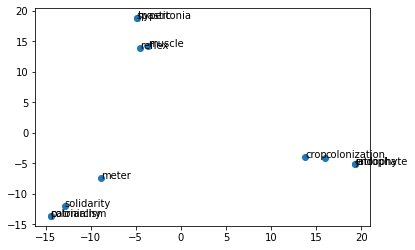

<Figure size 1080x1080 with 0 Axes>

In [26]:
from matplotlib import pyplot

pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(samples):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

pyplot.figure(figsize=(15,15))
pyplot.show()

### Future Directions

- Term Frequency
    - Apply TF transformation when counting words. (`Sublinear tranformation`, `BM25`)
    - Apply smoothing
    

- Embedding
    - Use cooccurence matrix to train word embeddings (Glove)
    - Or, load word embedding from Glove or Word2Vec and project words onto 2D plot.
    - Evalutate the similarity of two words by using `l1 distance`, `l2 distance`, or `cosine similiarity`.
    
    
- Different Approach
    - Try `query expansion`
    - Try `information retrieval` methods to infinitely expand the knowledge graph


- Metric
    - We may investigate `NPMI`
    - `Entropy`

### References
- running pyspark in jupyter
    - https://medium.com/@Vatsal410/running-pyspark-on-an-aws-cluster-through-jupyter-notebook-fe28f6ef47a4
    - https://medium.com/@christo.lagali/run-jupyter-notebooks-with-pyspark-on-an-emr-cluster-9630ef54c4e1
    - https://towardsdatascience.com/getting-started-with-pyspark-on-amazon-emr-c85154b6b921
- reading and writing in Amazon s3
    - https://docs.cloudera.com/runtime/7.0.2/developing-spark-applications/topics/spark-examples-of-accessing-s3-data-from-spark.html
- textmining in apache spark
    - https://runawayhorse001.github.io/LearningApacheSpark/textmining.html
    - https://medium.com/@serkansakinmaz/how-to-connect-amazon-s3-via-emr-based-pyspark-42707d540881
- How to setup spark cluster in AWS
    - https://aws.amazon.com/blogs/big-data/best-practices-for-successfully-managing-memory-for-apache-spark-applications-on-amazon-emr/

- Extract keywords in document
    - https://stackoverflow.com/questions/48869922/how-to-efficiently-check-if-a-list-of-words-is-contained-in-a-spark-dataframe
    - https://stackoverflow.com/questions/46410887/pyspark-string-matching-to-create-new-column
      
- Useful tutorials
   - https://spark.apache.org/docs/1.6.3/ml-features.html
   
- Word embeddings and visualization
   - https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html
   - https://machinelearningmastery.com/develop-word-embeddings-python-gensim/  